# chapter 7: Ensemble Learning and Random Forest

Existe um conceito chamado 'wisdom of the crowd' ou sabedoria popular. Vários estudos mostram que ouvir opiniões das pessoas pode ser uma boa forma de estimar algum fenômeno.

Em ML não é diferente! **Se nós agregarmos as predições de um grupo de preditores, obteremos resultados melhores que com o melhor preditor individualmente.**

Um grupo de preditores é chamado de **ensemble**

Exemplo: treine um conjunto de árvores de decisão em diferentes subconjuntos do dataset e use a resposta média para prever o resultado. Pronto, isso é uma Random Forest! Apesar de sua simplicidade, esse algoritmo é um dos mais poderoso na atualidade.

Vamos, então, cair de boca no ensemble learning. Falaremos de bagging, boosting, stacking e outros!

## Voting Classifiers

Suponha que você treinou alguns classificadores - vamos supor 5 deles (regressão logística, svm, random forest, knn, ...).

Cada um com 80% de acurácia (isso é uma boa métrica?). Queremos distinguir uma instância entre 2 classes: A e B.

O vetor de predição dos nossos modelos é:
(A, A, A, B, A)

Surpreendentemente, essa votação em geral consegue um resultado melhor que o resultado do melhor classificador. 

Mesmo que cada modelo seja um 'weak learner' (performa pouco melhor que um chute aleatório), o emsemble deles pode ser um 'strong learner' (alta performance).

Métodos de ensemble funcionam melhor quando os preditores são independentes entre si. Uma forma de obter isso é usando algoritmos muito diferentes. Isso vai levar a tipos de erros diferentes e, portanto, a uma melhora da performance do ensemble.


--------------
Vamos criar um ensemble!

--------------------




KNeighborsClassifier 0.8880597014925373 0.88



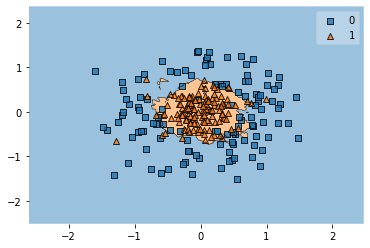


RandomForestClassifier 0.8837209302325582 0.88



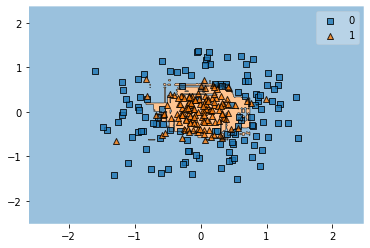


SVC 0.8988764044943821 0.892



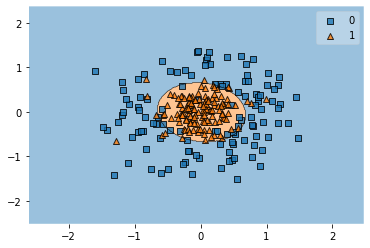


VotingClassifier 0.8872180451127819 0.88



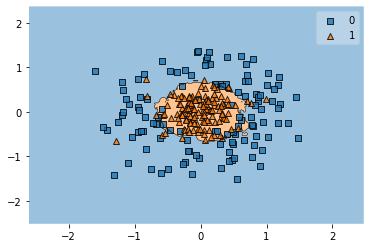

In [9]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_moons, make_circles
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

knn_clf = KNeighborsClassifier()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

#X, y = make_moons(10000, noise = 0.08, random_state=100)

X, y = make_circles(1000, noise = 0.3, factor= 0.1, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y)

voting_clf = VotingClassifier(
    estimators = [
        ('knn', knn_clf),
        ('rf', rnd_clf),
        ('svc', svm_clf),
    ],
    voting='hard'
)

#voting_clf.fit(X_train, y_train)

from sklearn.metrics import f1_score, accuracy_score

for clf in (knn_clf, rnd_clf, svm_clf, voting_clf):

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print()
    print(clf.__class__.__name__, f1_score(y_test, y_pred), accuracy_score(y_test, y_pred))
    print()

    plt.figure()
    plot_decision_regions(X_test, y_test, clf)
    plt.show()

Se todos os preditores possuírem o método predict_proba torna-se possível usar voting = 'soft' que usa a média dos predict_proba's para determinar a classe.


## Bagging and Pasting

Uma forma de criar bons ensembles é usando vários modelos com algoritmos muito distintos. Por outro lado, existe a possibilidade de treinar vários modelos iguais sobre subconjuntos aleatórios do dataset!

Quando amostramos com reposição o processo é chamado de **bagging** (short for
bootstrap aggregating)

Quando amostramos sem reposição o processo é chamado de **Pasting**

Um dos grandes bizus é que isso permite treinar e prever usando computação paralela.

### Bagging and Pasting no sklearn

BaggingClassifier/BaggingRegressor

Decision tree


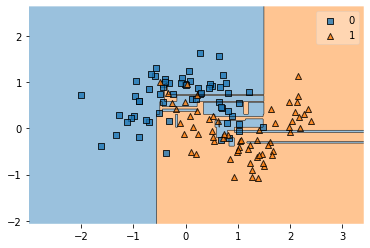

bagging de decisions tree


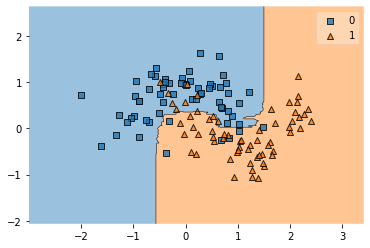

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = make_moons(500, noise = 0.3, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y)
# voting = 'soft' automático (se for possível)

tree_clf = DecisionTreeClassifier()
bag_clf = BaggingClassifier(
    
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1
    
    )
tree_clf.fit(X_train, y_train)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
#print('f1: ',f1_score(y_test, y_pred))
#print('acc:', accuracy_score(y_test, y_pred))
plt.figure()
print('Decision tree')
plot_decision_regions(X_test, y_test, tree_clf)
plt.show()
plt.figure()
print('bagging de decisions tree')
plot_decision_regions(X_test, y_test, bag_clf)
plt.show()

## Out-of-bag evaluation

Com o bagging, algumas instâncias podem ser amostradas várias vezes para um determinado preditor enquanto outras podem até não serem amostradas. Em geral 63% doas instancias de treino são amostradas para cada preditor. Os outros 37% não amostrados são chamados de instâncias out-of-bag (oob). Perceba que não são os mesmos 37% para todos os preditores.

Uma vez que um preditor nunca viu as oobs durante o treino, ele pode ser testado nessas instâncias sem a necessidade de um set separado de validação. Você pode testar o ensemble fazendo a média das métricas de cada preditor sobre os out of bag.

No sklearn use oob_score=True quando criar um BaggingClassifier para ter uma teste automático sobre o oob após o treino

In [11]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True
)
bag_clf.fit(X_train, y_train)
print('oob: ', bag_clf.oob_score_)

from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
print('testset: ',accuracy_score(y_test, y_pred))

oob:  0.8853333333333333
testset:  0.88


## Random patches and random subspaces

O BaggingClassifier suporta amostrar features também. Isso é controlado por 2 hiperparâmetros: max_features e bootstrap_features. Com isso, cada preditor vai ser treinado em um subconjunto aleatório das features de entrada.

Isso é particulamente interessante para entradas de grande nº de dimensões (como imagens). 

Amostrar features e instâncias simultaneamente é uma técnica chamada *Random Patches method*. Manter todas as instâncias e amostrar apenas as features é chamado de *Random Subspaces method*

Amostrar features resulta em mais diversidade de preditores. Adicionamos mais viés por um erro de variância menor.

## Random Forests

As florestas aleatórias são exatamente ensembles de árvores de decisão. Normalmente agrupadas na estratégia de Bagging (as vezes pasting). Para usá-las é melhor usar os modelos já prontos do sklearn: **RandomForestClassifier e RandomForestRegressor**

In [4]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)

rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [5]:
accuracy_score(y_test, y_pred_rf)

0.84

O algoritmo de floresta adicionas algumas aleatoriedades quando vai crescendo as árvores. Uma delas é a amostragem de features e instâncias.

### Extra-Trees (Extremely Randomized Trees ensemble)

É como um floresta mas usa thresholds aleatórios para cada feature na hora da quebra ao invés de procurar pelo melhor threshold.

Adiciona mais bias aos modelos.

É muito rápido de treinar.

Não é possível dizer qual dos dois modelos se sai melhor. Só metendo cross-val com os dois. Geralmente possuem desempenho parecido.


### Feature importance

Se você olhar para uma árvore de decisão solitária, features importantes tendem a aparecer próximas a raíz enquanto features menos importantes tendem a aparecer mais próximo as folhas.

COM ISSO, podemos estimar uma métrica de feature importance ao computar a média da profundidade daquela feature ao longo das árvores da floresta.

no sklearn: your_model.feature_importances_

In [6]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.0951504582775992
sepal width (cm) 0.024680375107342778
petal length (cm) 0.43516122647249067
petal width (cm) 0.4450079401425674


Random forests são úteis para ter um entendimento rápido das features que realmente importam.

## Boosting

Boosting se refere a qualquer método de ensemble que combina vários 'weak learners' em um 'strong learner'.

A ideia geral dos métodos de boosting é treinar preditores sequencialmente, cada um tentando consertar o erro de seu antecessor.

Existem infinitos Boosting's por aí, vamos falar do AdaBoost e do Gradiente Boosting. Sugiro conhecer o catboost e o LGBM pra quem quer usar isso de verdade.

### AdaBoost

Uma forma de um novo preditor corrigir os erros do antecessor é prestar mais atenção para a instâncias que o antecessor underfitou. Isso faz com que novos preditores foquem mais e mais nas instâncias difíceis. Essa é a técnica usada no AdaBoost.

Por exemplo, para usar um classificador AdaBoost, um classificador base (uma árvore de decisão por exmeplo) é treinado e usado para fazer predições no set de treino. Então o peso relativo de instâncias mal classificadas é aumentado e um novo preditor tenta aprender e assim por diante.

![](./imgs/adaboost.png)

Aqui temos o efeito da adição de novos modelos. O segundo gráfico está com learning rate -0.5 o que significa que as instâncias erradas pesam menos na hora da correção.
![](./imgs/ada.png)

Desvantagem: não dá para paralelizar.

No algoritmo AdaBoost cada instância começa com peso $w^{(i)}$ iniciado como $\frac{1}{m}$. Depois do primeiro preditor ser treinado, a taxa de erro ponderada $r_1$ é calculada no dataset de treino

$$r_j = \frac{\sum_{i=1, ŷ^{(i)}_j \neq ŷ^{(i)}}^{m}{w^{(i)}}}{\sum_{i=1}^{m}{w^{(i)}}}$$

Basicamente a soma dos pesos errados sobre a soma de todos os pesos. Daí, calculamos $\alpha_j$

$$ \alpha_j = \eta \cdot log{\frac{1-r_j}{r_j}} $$

Então os novos pesos são calculados:

$$
 w^{(i)} = \begin{cases}
    w^{(i)}, & \text{if } ŷ_j^{(i)} = y^{(i)}\\
    w^{(i)} \cdot exp(\alpha_j), & \text{if } ŷ_j^{(i)} \neq y^{(i)}
\end{cases}
$$

E aí todos os pesos são normalizados (dividindo tudo pelo somatório de todos os pesos)

Finalmente um novo preditor é treinado usando os pesos atualizados e todo o processo é repetido. O processo termina quando se atinge um número determinado de preditores ou quando um preditor perfeito é encontrado.

#### predições

$$
ŷ(\pmb x) = \underset{k}{argmax} \sum^{N}_{\underset{ŷ_j(x) = k}{j = 1}} \alpha_j
$$

É o cálculo das predições de todos os preditores com seus pesos. A classe predita é a que recebe a maior quantidade de votos ponderados.

In [7]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME.R", # variação do modelo: consegue lidar com multiclasse e usa predict_proba
    learning_rate=0.5
    )

# Perceba que o estimador base é muito regularizado (weak learner)
ada_clf.fit(X_train, y_train)
ada_clf.score(X_test, y_test)

0.872

### Gradient Boosting

Trabalha adicionando preditores em um ensemble, cada um corrigindo o antecessor. Mas ao invés de mudar pesos de instâncias a cada passo, esse método tenta fitar o novo preditor em cima do erro residual do preditor passado.


In [8]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)

![](./imgs/gb.png)

O learning rate escala a contribuição de cada árvore, se ele for baixo, você vai precisar de mais árvores pra fitar, mas normalmente vai generalizar melhor também.

![](./imgs/gb2.png)

Para achar o número ótimo de árvores normalmente se usa early stopping já discutido anteriormente.
![](./imgs/gb3.png)

Stochastic Gradient Boosting: cada estimador treina sobre apenas uma fração dos dados.

## Stacking

TREINAR UM MODELO (blender ou meta learner) PARA AGREGAR AS PREVISÕES DE OUTROS MODELOS E DAR A PALAVRA FINAL: ULTRA STONKS.

Para isso você vai precisar dividir o dataset de treino em treino dos modelos e treino do blender (hold-out set).



![](./imgs/stacking.png)

Dá pra fazer camadas de blending também!
![](./imgs/blending2.png)

sklearn não tem stacking implementado mas é fácil fazer. Uma alternativa é usar o 'brew'

# FIM

Sugou os exercicios por enquanto, comp ta dificil :(
